In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/NIFTY50.csv


In [12]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
%matplotlib inline

In [13]:
data = pd.read_csv("/kaggle/input/dataset/NIFTY50.csv")
data

,DATE,OPEN,HIGH,CLOSE,LOW,SHARES_TRADED
0,2015-11-09,7788.25,7937.75,7915.20,7771.70,2.184224e+08
1,2015-11-10,7877.60,7885.10,7783.35,7772.85,1.702674e+08
2,2015-11-11,7838.80,7847.95,7825.00,7819.10,2.238044e+07
3,2015-11-13,7762.45,7775.10,7762.25,7730.90,1.658768e+08
4,2015-11-16,7732.95,7838.85,7806.60,7714.15,1.541349e+08
...,...,...,...,...,...,...
2127,2024-06-04,23179.50,23179.50,21884.50,21281.45,1.006105e+09
2128,2024-06-05,22128.35,22670.40,22620.35,21791.95,6.384871e+08
2129,2024-06-06,22798.60,22910.15,22821.40,22642.60,4.804133e+08
2130,2024-06-07,22821.85,23320.20,23290.15,22789.05,4.735549e+08


In [14]:
data['CLOSE_NEXT']=data['CLOSE'].shift(1)

In [15]:
data.dropna(inplace=True)

In [16]:
data['DATE']=pd.to_datetime(data['DATE'])

In [17]:
train = data[:int(0.8*len(data))]
test = data[int(0.8*len(data)):]

In [18]:
train

,DATE,OPEN,HIGH,CLOSE,LOW,SHARES_TRADED,CLOSE_NEXT
1,2015-11-10,7877.60,7885.10,7783.35,7772.85,170267413.0,7915.20
2,2015-11-11,7838.80,7847.95,7825.00,7819.10,22380435.0,7783.35
3,2015-11-13,7762.45,7775.10,7762.25,7730.90,165876819.0,7825.00
4,2015-11-16,7732.95,7838.85,7806.60,7714.15,154134885.0,7762.25
5,2015-11-17,7848.75,7860.45,7837.55,7793.00,149451211.0,7806.60
...,...,...,...,...,...,...,...
1701,2022-09-22,17609.65,17722.75,17629.80,17532.45,284094023.0,17718.35
1702,2022-09-23,17593.85,17642.15,17327.35,17291.65,390754862.0,17629.80
1703,2022-09-26,17156.30,17196.40,17016.30,16978.30,492002942.0,17327.35
1704,2022-09-27,17110.90,17176.45,17007.40,16942.35,359895458.0,17016.30


In [19]:
data.dtypes

DATE             datetime64[ns]
OPEN                    float64
HIGH                    float64
CLOSE                   float64
LOW                     float64
SHARES_TRADED           float64
CLOSE_NEXT              float64
dtype: object

<Figure size 2000x1400 with 0 Axes>

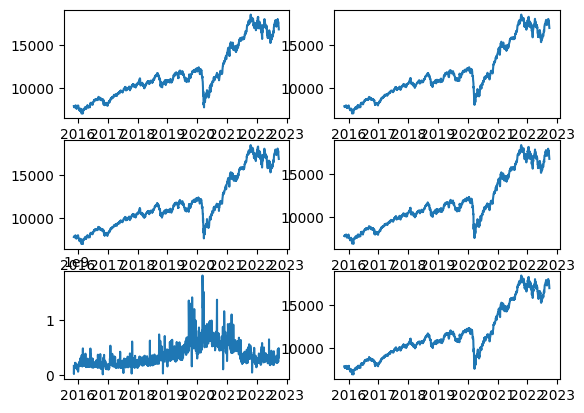

In [20]:
plt.figure(figsize=(20,14))
figure, axes = plt.subplots(nrows=3,ncols=2)
axes[0,0].plot(train['DATE'],train['OPEN'],label= 'Open')
axes[0,1].plot(train['DATE'],train['HIGH'],label= 'High')
axes[1,0].plot(train['DATE'],train['CLOSE'],label= 'Close')
axes[1,1].plot(train['DATE'],train['LOW'],label= 'Low')
axes[2,0].plot(train['DATE'],train['SHARES_TRADED'],label= 'Shares_Traded')
axes[2,1].plot(train['DATE'],train['CLOSE_NEXT'],label= 'Close Next')

In [21]:
train.rename(columns={'CLOSE_NEXT':'y','DATE':'ds'},inplace=True)
train.head()

/tmp/ipykernel_34/2293102106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={'CLOSE_NEXT':'y','DATE':'ds'},inplace=True)


,ds,OPEN,HIGH,CLOSE,LOW,SHARES_TRADED,y
1,2015-11-10,7877.60,7885.10,7783.35,7772.85,170267413.0,7915.20
2,2015-11-11,7838.80,7847.95,7825.00,7819.10,22380435.0,7783.35
3,2015-11-13,7762.45,7775.10,7762.25,7730.90,165876819.0,7825.00
4,2015-11-16,7732.95,7838.85,7806.60,7714.15,154134885.0,7762.25
5,2015-11-17,7848.75,7860.45,7837.55,7793.00,149451211.0,7806.60


In [22]:
test.rename(columns={'CLOSE_NEXT':'y','DATE':'ds'},inplace=True)
test.head()

/tmp/ipykernel_34/959454477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rename(columns={'CLOSE_NEXT':'y','DATE':'ds'},inplace=True)


,ds,OPEN,HIGH,CLOSE,LOW,SHARES_TRADED,y
1706,2022-09-29,16993.60,17026.05,16818.10,16788.60,340034380.0,16858.60
1707,2022-09-30,16798.05,17187.10,17094.35,16747.70,380204763.0,16818.10
1708,2022-10-03,17102.10,17114.65,16887.35,16855.55,285850587.0,17094.35
1709,2022-10-04,17147.45,17287.30,17274.30,17117.30,231601639.0,16887.35
1710,2022-10-06,17379.25,17428.80,17331.80,17315.65,268239320.0,17274.30


In [23]:
model = Prophet()
model.add_regressor("OPEN",standardize=False)
model.add_regressor("HIGH",standardize=False)
model.add_regressor("CLOSE",standardize=False)
model.add_regressor("LOW",standardize=False)
model.add_regressor("SHARES_TRADED",standardize=False)
model.fit(train)

10:24:40 - cmdstanpy - INFO - Chain [1] start processing
10:24:40 - cmdstanpy - INFO - Chain [1] done processing
10:24:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
10:24:40 - cmdstanpy - INFO - Chain [1] start processing
10:26:45 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
model.params

OrderedDict([('lp__', array([[8514.28]])),
             ('k', array([[0.00155942]])),
             ('m', array([[0.00138692]])),
             ('delta',
              array([[ 1.95591e-03,  7.79070e-08, -1.99170e-05, -1.62783e-04,
                       1.15753e-08,  4.80368e-08, -1.47046e-05, -7.17663e-07,
                      -7.83336e-08, -3.91699e-04, -4.92286e-03,  1.42155e-08,
                      -1.42114e-08,  7.98206e-08,  7.16771e-04,  2.76644e-04,
                       2.53246e-03,  4.90176e-04, -7.57856e-02,  9.05861e-02,
                       2.37848e-04,  9.34915e-08, -1.28413e-08,  2.10321e-02,
                      -2.96427e-02]])),
             ('sigma_obs', array([[0.00408909]])),
             ('beta',
              array([[ 1.03297e-05,  6.74855e-05,  1.93308e-04,  1.44299e-04,
                      -4.26433e-05, -2.50943e-05, -1.62853e-04, -4.95806e-05,
                       4.45857e-05, -1.51738e-04, -1.64679e-04,  2.80183e-04,
                       2.94391e-0

In [25]:
test.rename(columns={'CLOSE_NEXT':'y','DATE':'ds'},inplace=True)
test.head()

/tmp/ipykernel_34/959454477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rename(columns={'CLOSE_NEXT':'y','DATE':'ds'},inplace=True)


,ds,OPEN,HIGH,CLOSE,LOW,SHARES_TRADED,y
1706,2022-09-29,16993.60,17026.05,16818.10,16788.60,340034380.0,16858.60
1707,2022-09-30,16798.05,17187.10,17094.35,16747.70,380204763.0,16818.10
1708,2022-10-03,17102.10,17114.65,16887.35,16855.55,285850587.0,17094.35
1709,2022-10-04,17147.45,17287.30,17274.30,17117.30,231601639.0,16887.35
1710,2022-10-06,17379.25,17428.80,17331.80,17315.65,268239320.0,17274.30


In [26]:
test1 = test[['ds','OPEN','HIGH','CLOSE','LOW','SHARES_TRADED']]

In [27]:
forecast= model.predict(test1)

In [28]:
forecast = forecast[['ds','yhat']]
forecast.head()

,ds,yhat
0,2022-09-29,17002.320988
1,2022-09-30,16874.121354
2,2022-10-03,17109.896757
3,2022-10-04,17129.282317
4,2022-10-06,17369.394174


In [29]:
final_df = pd.merge(test, forecast, on='ds', how='left')
final_df

,ds,OPEN,HIGH,CLOSE,LOW,SHARES_TRADED,y,yhat
0,2022-09-29,16993.60,17026.05,16818.10,16788.60,3.400344e+08,16858.60,17002.320988
1,2022-09-30,16798.05,17187.10,17094.35,16747.70,3.802048e+08,16818.10,16874.121354
2,2022-10-03,17102.10,17114.65,16887.35,16855.55,2.858506e+08,17094.35,17109.896757
3,2022-10-04,17147.45,17287.30,17274.30,17117.30,2.316016e+08,16887.35,17129.282317
4,2022-10-06,17379.25,17428.80,17331.80,17315.65,2.682393e+08,17274.30,17369.394174
...,...,...,...,...,...,...,...,...
433,2024-06-04,23179.50,23179.50,21884.50,21281.45,1.006105e+09,23263.90,23287.453708
434,2024-06-05,22128.35,22670.40,22620.35,21791.95,6.384871e+08,21884.50,22186.933342
435,2024-06-06,22798.60,22910.15,22821.40,22642.60,4.804133e+08,22620.35,22797.282197
436,2024-06-07,22821.85,23320.20,23290.15,22789.05,4.735549e+08,22821.40,22908.878409


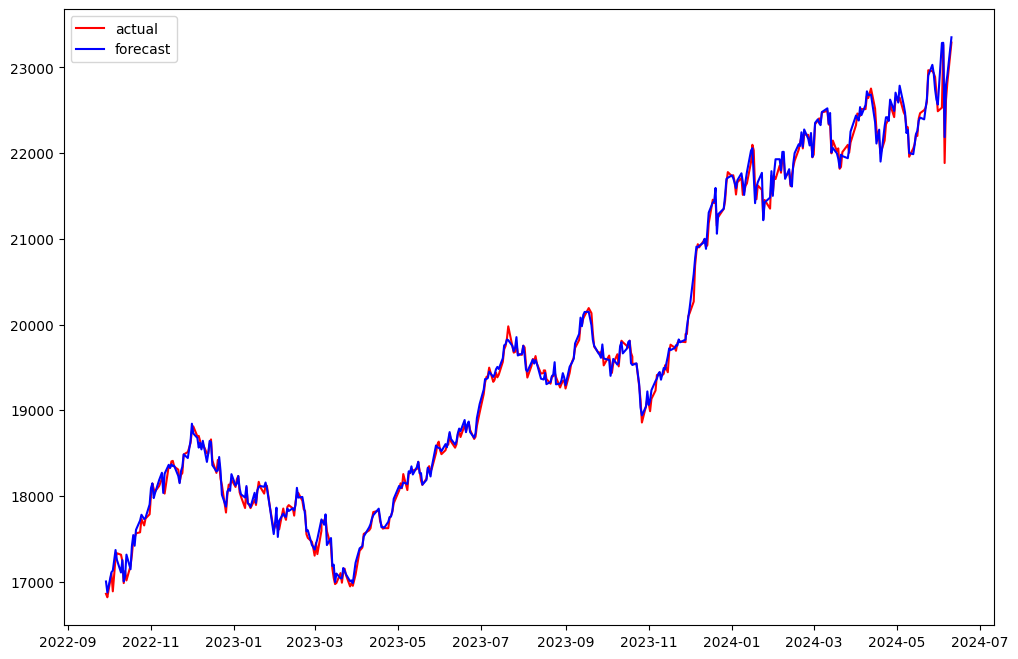

In [30]:
plt.figure(figsize=(12,8))
plt.plot(final_df['ds'],final_df['y'],color='red',label='actual')
plt.plot(final_df['ds'],final_df['yhat'],color='blue',label='forecast')
plt.legend()

In [31]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [32]:
mape=mean_absolute_percentage_error(final_df['y'], final_df['yhat'])
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error(final_df['y'], final_df['yhat'])
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("="*50)

Mean Absolute Percentage Error 0.0030892583183498986
Mean Squared Error 7426.868379240949
RMSE 86.17928045209561


In [33]:
output=pd.DataFrame()
output['Test']=final_df['y']
output['Prediction']=final_df['yhat']
output['Difference']=output['Test']-output['Prediction']
output['% Chnage']=abs(output['Difference']/output['Test'])*100
output

,Test,Prediction,Difference,% Chnage
0,16858.60,17002.320988,-143.720988,0.852508
1,16818.10,16874.121354,-56.021354,0.333102
2,17094.35,17109.896757,-15.546757,0.090947
3,16887.35,17129.282317,-241.932317,1.432625
4,17274.30,17369.394174,-95.094174,0.550495
...,...,...,...,...
433,23263.90,23287.453708,-23.553708,0.101246
434,21884.50,22186.933342,-302.433342,1.381952
435,22620.35,22797.282197,-176.932197,0.782182
436,22821.40,22908.878409,-87.478409,0.383317


In [34]:
output.describe()

,Test,Prediction,Difference,% Chnage
count,438.000000,438.000000,438.000000,438.000000
mean,19628.602854,19644.188189,-15.585335,0.308926
std,1779.436721,1779.961194,84.855200,0.299517
min,16818.100000,16874.121354,-754.508004,0.000917
25%,18119.537500,18116.991265,-56.585335,0.113120
50%,19412.750000,19409.272427,-15.602186,0.242271
75%,21516.262500,21571.115427,30.497996,0.400077
max,23290.150000,23351.743497,300.449868,3.348800
